In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import keras.backend as K

import scipy.io as io

import math

import PIL
import os

In [120]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def picture_to_array(filename, size=(64, 64)):
    image = PIL.Image.open(filename)
    image.thumbnail(size=size)
    small = image.resize(size)
    arr = np.array(small)
    good_arr = arr
    if len(arr.shape) == 3:
        if arr.shape[2] > 3:
            good_arr = np.delete(arr, axis=2, obj=3)
    elif len(arr.shape) == 2:
        good_arr = np.array([good_arr, good_arr, good_arr])
    if good_arr.shape == (size[0], size[1], 3):
        return True, good_arr
    else:
        return False, None
    
def read_data_int(males=False, size=(64, 64), test=False):
    if not males and not test:
        dir = '../data/male_female/data/train/0_female/'
    elif males and not test:
        dir = '../data/male_female/data/train/1_male/'
    elif not males and test:
        dir = '../data/male_female/data/test/0_female/'
    elif males and test:
        dir = '../data/male_female/data/test/1_male/'
    print("Checking ", dir)
    x = []
    y = []
    for dirname, _, filenames in os.walk(dir):
        for filename in filenames:
            good, pic = picture_to_array(os.path.join(dirname, filename), size)
            if good:
                x.append(pic)
                if males:
                    y.append(1)
                else:
                    y.append(0)
    return x, y

def normalize_images(ims):
    return ims / 255.0

def read_data(size=(64, 64), test=False):
    x_male, y_male = read_data_int(True, size, test)
    x_female, y_female = read_data_int(False, size, test)
    x, y = normalize_images(np.array(x_male + x_female)), np.array(y_male + y_female)
    shuffle_in_unison(x, y)
    return x, y

In [121]:
size=(64, 64)
x_train, y_train = read_data(size=size)
x_test, y_test = read_data(test=True, size=size)

Checking  ../data/male_female/data/train/1_male/
Checking  ../data/male_female/data/train/0_female/
Checking  ../data/male_female/data/test/1_male/
Checking  ../data/male_female/data/test/0_female/


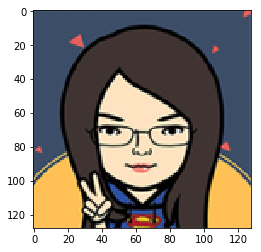

In [4]:
plt.imshow(x_train[2])

In [152]:
def check_gender(model, filename):
    good, im = picture_to_array(filename, size=size)
    cls = model.predict(normalize_images(np.array([im])))
    if cls[0][0] < 0.5:
        print("Female :", 1 - cls[0][0])
    else:
        print("Male ", cls[0][0])

def check_gender_arr(model, arr):
    good, im = picture_to_array(filename, size=size)
    cls = model.predict(normalize_images(np.array([im])))
    if cls[0][0] < 0.5:
        print("Female :", 1 - cls[0][0])
    else:
        print("Male ", cls[0][0])
        
def build_model():
    K.clear_session()

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
__________

In [153]:
model.fit(x_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
11119/11119 [==============================] - 7s - loss: 0.5898 - acc: 0.6877     
Epoch 2/15
11119/11119 [==============================] - 6s - loss: 0.4561 - acc: 0.7760     
Epoch 3/15
11119/11119 [==============================] - 6s - loss: 0.3858 - acc: 0.8163     
Epoch 4/15
11119/11119 [==============================] - 6s - loss: 0.3227 - acc: 0.8529     
Epoch 5/15
11119/11119 [==============================] - 6s - loss: 0.2466 - acc: 0.8952     
Epoch 6/15
11119/11119 [==============================] - 6s - loss: 0.1826 - acc: 0.9267     
Epoch 7/15
11119/11119 [==============================] - 6s - loss: 0.1334 - acc: 0.9478     
Epoch 8/15
11119/11119 [==============================] - 6s - loss: 0.0910 - acc: 0.9673     
Epoch 9/15
11119/11119 [==============================] - 6s - loss: 0.0670 - acc: 0.9776     
Epoch 10/15
11119/11119 [==============================] - 6s - loss: 0.0484 - acc: 0.9827     
Epoch 11/15
11119/11119 [========================

In [158]:
model.evaluate(x_test, y_test)

2624/2784 [===========================>..] - ETA: 0s

[2.0972471360502571, 0.56609195402298851]

In [12]:
model.fit(x_test, y_test, epochs = 10, verbose = 0, batch_size=64)

In [104]:
check_gender(model, '../data/male_female/data/test/Long-hair-can-give-you-a-more-relaxed-look.jpg')

Female : 0.983630500734


 =========================== Extra training with imdb data ===================================

In [ ]:
data = load_imdb_data()

In [81]:
x, y = load_imdb(data, "D:/data/imdb_crop/", 0, 10000)

1


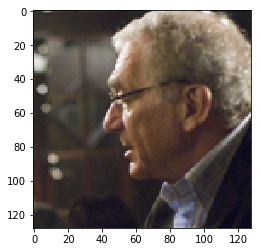

In [85]:
pos = 293
plt.imshow(x[pos])
print(y[pos])

In [156]:
def load_imdb_data():
    m = io.loadmat("D:/data/imdb_crop/imdb_meta/imdb/imdb.mat")
    return m['imdb']

def load_imdb(data, dirname, offset, count):
    x = []
    y = []
    for i in range(offset, offset + count):
        if math.isnan(data[0][0][3][0][i]):
            continue
        f = data[0][0][2][0][i][0]
        g = int(data[0][0][3][0][i])
        good, pic = picture_to_array(os.path.join(dirname, f), size)
        if good:
            x.append(pic)
            y.append(g)
    x = np.array(x)
    y = np.array(y)
    shuffle_in_unison(x, y)
    return x, y

def train_imdb(model, max_batches = 100000, startIdx = 0):
    data = load_imdb_data()
    batch_size = 10000
    print("Loaded data, begin training")
    batches = min(max_batches, len(data[0][0][3][0]) // batch_size) 
    for batch in range(startIdx, startIdx + batches):
        print("Batch ", batch, "/", batches)
        x, y = load_imdb(data, "D:/data/imdb_crop/", batch * batch_size, batch_size)
        x = normalize_images(x)
        #print(x.shape)
        model.fit(x, y, epochs=10, batch_size=64)

In [157]:
train_imdb(model, 3, 10)

Loaded data, begin training
Batch  10 / 3
Epoch 1/10
8935/8935 [==============================] - 4s - loss: 0.7807 - acc: 0.6580     
Epoch 2/10
8935/8935 [==============================] - 4s - loss: 0.4891 - acc: 0.7633     
Epoch 3/10
8935/8935 [==============================] - 4s - loss: 0.4068 - acc: 0.8112     
Epoch 4/10
8935/8935 [==============================] - 4s - loss: 0.3061 - acc: 0.8722     
Epoch 5/10
8935/8935 [==============================] - 4s - loss: 0.2188 - acc: 0.9110     
Epoch 6/10
8935/8935 [==============================] - 4s - loss: 0.1399 - acc: 0.9521     
Epoch 7/10
8935/8935 [==============================] - 4s - loss: 0.0904 - acc: 0.9728     
Epoch 8/10
8935/8935 [==============================] - 4s - loss: 0.0664 - acc: 0.9822     
Epoch 9/10
8935/8935 [==============================] - 4s - loss: 0.0465 - acc: 0.9886     
Epoch 10/10
8935/8935 [==============================] - 4s - loss: 0.0352 - acc: 0.9919     
Batch  11 / 3
Epoch 1/10
90

In [15]:
def get_gender(model, arr, shape=(64, 64)):
    im = PIL.Image.fromarray(arr)
    good_size_arr = np.array(im.resize(shape))
    if len(arr.shape) == 2:
        good_size_arr = np.array([good_size_arr, good_size_arr, good_size_arr])
    cls = model.predict(np.array([normalize_images(good_size_arr)]))
    if cls[0][0] < 0.5:
        return "Female"
    else:
        return "Male"

def save_model(model_filename='model.json', weights_filename='model.h5'):
    model_json = model.to_json()
    with open(model_filename, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weights_filename)
    print("Saved model to disk")

In [155]:
save_model()

Saved model to disk
